### Goal

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pathlib import Path

In [13]:
import os
directory = '/Users/michaelmoret/tinyverse/krap/strand_script'
try:
    files = os.listdir(directory)
    print("Files in directory:")
    for file in files:
        if 'gradient' in file.lower() or '2025' in file:
            print(f"Found: '{file}'")
except FileNotFoundError:
    print("Directory not found")

Files in directory:
Found: 'Yield Gradient SOP.pdf'
Found: '20250310$50% IHNY virgin$50% IHNY High heat damage$yield gradient.txt'
Found: '20250409$1hr hot$IHNY high heat damage$50% phos ctrl $50% ELI-2-4-K 0.06$yield gradient.txt'
Found: '20250415$Leave-in $IHNY high heat damage$50% SDS wash ctrl $50% K-18 cream$yield gradient.txt'
Found: '20250410$1hr$IHNY high heat damage$50% phos ctrl $50% SH-oligo 0.06$yield gradient.txt'
Found: '20250603 $1H COLD $IHNY HIGH HEAT $50% CONDITIONER BASE $50% KP-M5-IV CREAM 0.06$yield gradient.txt'
Found: '20250410$1hr$IHNY high heat damage$50% phos ctrl $50% olaplex 0.06$yield gradient.txt'


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def remove_outliers_iqr(data, k=1.5):
    """
    Remove outliers using the IQR method.
    
    Parameters:
    data: array-like, input data
    k: float, multiplier for IQR (default 1.5 for standard outlier detection)
    
    Returns:
    cleaned_data: array with outliers removed
    """
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    # Filter data within bounds
    cleaned_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    return cleaned_data

def do_plot(df, data_1, data_2, name_1, name_2, outlier_method='iqr', k=1.5):
    """
    Create boxplot with statistical significance testing after outlier removal.
    
    Parameters:
    df: DataFrame (for reference, not used in current implementation)
    data_1, data_2: array-like, the two datasets to compare
    name_1, name_2: str, names for the datasets
    outlier_method: str, method for outlier removal ('iqr' or 'zscore')
    k: float, parameter for outlier detection (IQR multiplier or Z-score threshold)
    """
    
    # Convert to numpy arrays if not already
    data_1 = np.array(data_1)
    data_2 = np.array(data_2)
    
    # Remove outliers from both datasets
    if outlier_method == 'iqr':
        data_1_clean = remove_outliers_iqr(data_1, k=k)
        data_2_clean = remove_outliers_iqr(data_2, k=k)
    elif outlier_method == 'zscore':
        # Z-score method: remove data points with |z-score| > k (default k=3)
        z_scores_1 = np.abs(stats.zscore(data_1))
        z_scores_2 = np.abs(stats.zscore(data_2))
        data_1_clean = data_1[z_scores_1 < k]
        data_2_clean = data_2[z_scores_2 < k]
    else:
        raise ValueError("outlier_method must be 'iqr' or 'zscore'")
    
    # Print outlier removal summary
    n_outliers_1 = len(data_1) - len(data_1_clean)
    n_outliers_2 = len(data_2) - len(data_2_clean)
    print(f"Outlier Removal Summary:")
    print(f"{name_1}: {n_outliers_1} outliers removed ({len(data_1_clean)}/{len(data_1)} points retained)")
    print(f"{name_2}: {n_outliers_2} outliers removed ({len(data_2_clean)}/{len(data_2)} points retained)")
    print()

    # Check if we have enough data points for statistical testing
    if len(data_1_clean) < 3 or len(data_2_clean) < 3:
        print("Warning: Too few data points after outlier removal for reliable statistical testing")
    
    # Perform statistical test (t-test for parametric data) on cleaned data
    statistic, p_value = stats.ttest_ind(data_1_clean, data_2_clean)

    # Determine significance level
    def get_significance_stars(p_val):
        if p_val < 0.001:
            return '***'
        elif p_val < 0.01:
            return '**'
        elif p_val < 0.05:
            return '*'
        else:
            return 'ns'  # not significant

    significance = get_significance_stars(p_value)

    # Create the boxplot using cleaned data
    fig, ax = plt.subplots(figsize=(4, 4))
    bp = ax.boxplot([data_1_clean, data_2_clean], labels=[name_1, name_2])

    # Add statistical significance annotation
    if significance != 'ns':
        # Get the maximum value for positioning the significance line
        y_max = max(data_1_clean.max(), data_2_clean.max())
        y_range = y_max - min(data_1_clean.min(), data_2_clean.min())
        y_pos = y_max + 0.05 * y_range  # Position above the highest point
        
        # Draw the significance line and stars
        ax.plot([1, 2], [y_pos, y_pos], 'k-', linewidth=1)
        ax.plot([1, 1], [y_pos, y_pos - 0.02 * y_range], 'k-', linewidth=1)
        ax.plot([2, 2], [y_pos, y_pos - 0.02 * y_range], 'k-', linewidth=1)
        
        # Add the significance stars
        ax.text(1.5, y_pos + 0.01 * y_range, significance, 
                horizontalalignment='center', fontsize=14, fontweight='bold')

    # Add p-value as text annotation
    ax.text(0.02, 0.98, f'p = {p_value:.4f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add subtitle indicating outlier removal
    ax.text(0.5, 0.02, f'Outliers removed using {outlier_method.upper()} method', 
            transform=ax.transAxes, horizontalalignment='center', 
            fontsize=8, style='italic', alpha=0.7)

    ax.set_ylabel('Yield Gradient')
    plt.tight_layout()
    plt.show()

    # Print statistical results
    print(f"Statistical Test Results (after outlier removal):")
    print(f"T-statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significance: {significance}")
    print(f"Mean {name_1}: {data_1_clean.mean():.4f} ± {data_1_clean.std():.4f}")
    print(f"Mean {name_2}: {data_2_clean.mean():.4f} ± {data_2_clean.std():.4f}")

Outlier Removal Summary:
Virgin: 0 outliers removed (49/49 points retained)
Heat: 1 outliers removed (47/48 points retained)



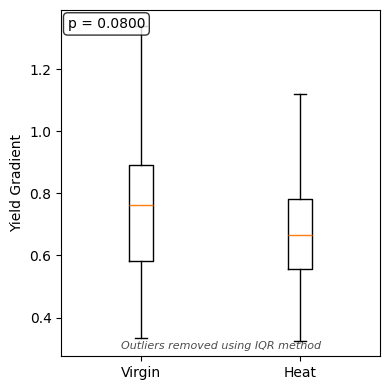

Statistical Test Results (after outlier removal):
T-statistic: 1.7696
P-value: 0.0800
Significance: ns
Mean Virgin: 0.7622 ± 0.2173
Mean Heat: 0.6870 ± 0.1935


In [15]:
path = '/Users/michaelmoret/tinyverse/krap/strand_script/20250310$50% IHNY virgin$50% IHNY High heat damage$yield gradient.txt'
path = Path(path)

df = pd.read_csv(path, sep='\t')
df['Yield gradient'] = (df['END_Y'] - df['START_Y']) / (df['END_X(*)'] - df['START_X(*)'])

virgin_data = df.iloc[0:50]['Yield gradient'].dropna()
heat_data = df.iloc[50:100]['Yield gradient'].dropna()

do_plot(df, virgin_data, heat_data, 'Virgin', 'Heat')

Outlier Removal Summary:
heat: 3 outliers removed (45/48 points retained)
ELI24K: 2 outliers removed (43/45 points retained)



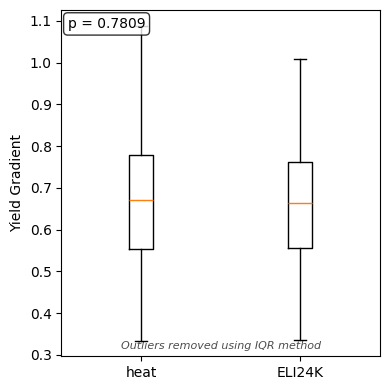

Statistical Test Results (after outlier removal):
T-statistic: 0.2790
P-value: 0.7809
Significance: ns
Mean heat: 0.6719 ± 0.1761
Mean ELI24K: 0.6619 ± 0.1556


In [16]:
path = '/Users/michaelmoret/tinyverse/krap/strand_script/20250409$1hr hot$IHNY high heat damage$50% phos ctrl $50% ELI-2-4-K 0.06$yield gradient.txt'
path = Path(path)

df = pd.read_csv(path, sep='\t')
df['Yield gradient'] = (df['END_Y'] - df['START_Y']) / (df['END_X(*)'] - df['START_X(*)'])

heat = df.iloc[0:50]['Yield gradient'].dropna()
ELI24K = df.iloc[50:100]['Yield gradient'].dropna()

do_plot(df, heat, ELI24K, 'heat', 'ELI24K')

Outlier Removal Summary:
heat: 2 outliers removed (37/39 points retained)
K18: 1 outliers removed (25/26 points retained)



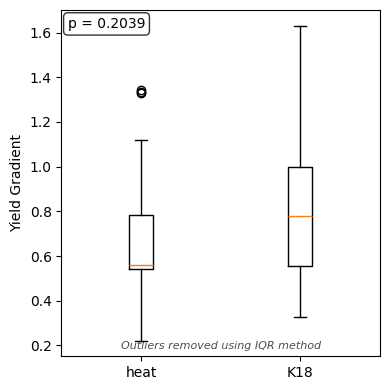

Statistical Test Results (after outlier removal):
T-statistic: -1.2845
P-value: 0.2039
Significance: ns
Mean heat: 0.6863 ± 0.2836
Mean K18: 0.7847 ± 0.3021


In [17]:
path = '/Users/michaelmoret/tinyverse/krap/strand_script/20250415$Leave-in $IHNY high heat damage$50% SDS wash ctrl $50% K-18 cream$yield gradient.txt'
path = Path(path)

df = pd.read_csv(path, sep='\t')
df['Yield gradient'] = (df['END_Y'] - df['START_Y']) / (df['END_X(*)'] - df['START_X(*)'])

heat = df.iloc[0:50]['Yield gradient'].dropna()
K18 = df.iloc[50:100]['Yield gradient'].dropna()

do_plot(df, heat, K18, 'heat', 'K18')

Outlier Removal Summary:
heat: 2 outliers removed (44/46 points retained)
KPM5: 1 outliers removed (40/41 points retained)



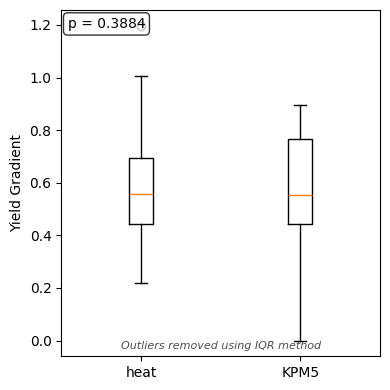

Statistical Test Results (after outlier removal):
T-statistic: 0.8672
P-value: 0.3884
Significance: ns
Mean heat: 0.5937 ± 0.2246
Mean KPM5: 0.5500 ± 0.2321


In [18]:
path = '/Users/michaelmoret/tinyverse/krap/strand_script/20250603 $1H COLD $IHNY HIGH HEAT $50% CONDITIONER BASE $50% KP-M5-IV CREAM 0.06$yield gradient.txt'
path = Path(path)

df = pd.read_csv(path, sep='\t')
df['Yield gradient'] = (df['END_Y'] - df['START_Y']) / (df['END_X(*)'] - df['START_X(*)'])

heat = df.iloc[0:50]['Yield gradient'].dropna()
KPM5 = df.iloc[50:100]['Yield gradient'].dropna()

do_plot(df, heat, KPM5, 'heat', 'KPM5')

Outlier Removal Summary:
heat: 1 outliers removed (23/24 points retained)
olaplex: 2 outliers removed (29/31 points retained)



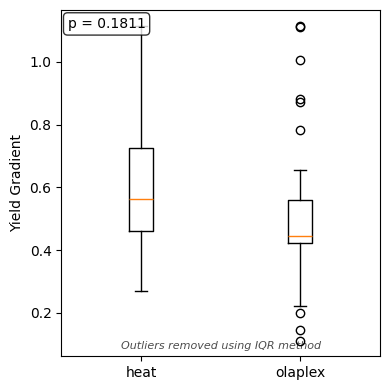

Statistical Test Results (after outlier removal):
T-statistic: 1.3562
P-value: 0.1811
Significance: ns
Mean heat: 0.6211 ± 0.2145
Mean olaplex: 0.5288 ± 0.2569


In [19]:
path = '/Users/michaelmoret/tinyverse/krap/strand_script/20250410$1hr$IHNY high heat damage$50% phos ctrl $50% olaplex 0.06$yield gradient.txt'
path = Path(path)

df = pd.read_csv(path, sep='\t')
df['Yield gradient'] = (df['END_Y'] - df['START_Y']) / (df['END_X(*)'] - df['START_X(*)'])

heat = df.iloc[0:50]['Yield gradient'].dropna()
olaplex = df.iloc[50:100]['Yield gradient'].dropna()

do_plot(df, heat, olaplex, 'heat', 'olaplex')

Outlier Removal Summary:
heat: 3 outliers removed (30/33 points retained)
SH oligo: 2 outliers removed (30/32 points retained)



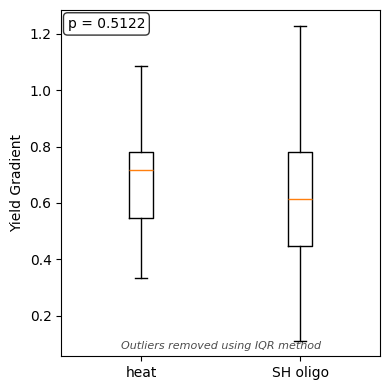

Statistical Test Results (after outlier removal):
T-statistic: 0.6594
P-value: 0.5122
Significance: ns
Mean heat: 0.6785 ± 0.1779
Mean SH oligo: 0.6427 ± 0.2317


In [20]:
path = '/Users/michaelmoret/tinyverse/krap/strand_script/20250410$1hr$IHNY high heat damage$50% phos ctrl $50% SH-oligo 0.06$yield gradient.txt'
path = Path(path)

df = pd.read_csv(path, sep='\t')
df['Yield gradient'] = (df['END_Y'] - df['START_Y']) / (df['END_X(*)'] - df['START_X(*)'])

heat = df.iloc[0:50]['Yield gradient'].dropna()
olaplex = df.iloc[50:100]['Yield gradient'].dropna()

do_plot(df, heat, olaplex, 'heat', 'SH oligo')